# Combining Chronos2 Foundational Time Series Models with PyMC-Marketing MMM

This notebook demonstrates how to combine **foundational time series forecasting models** (Chronos2) with **causal inference models** (PyMC-Marketing MMM) to get the best of both worlds:

- **Chronos2**: State-of-the-art predictive accuracy for forecasting control variables
- **PyMC-Marketing MMM**: Causal understanding of media effects and optimal budget allocation

## The Problem

In real-world media mix modeling, control variables (e.g., employment rates, temperature) are often:
- **Unavailable** for future periods (we need forecasts to plan campaigns)
- **Critical** for accurate media effect estimation (controls capture confounding)

## The Solution

1. **Train MMM** on historical data (Years 1-3) to learn causal relationships
2. **Use Chronos2** to forecast control variables for the future period (Year 4)
3. **Combine** forecasted controls with known media spend to predict sales
4. **Evaluate** accuracy against actual outcomes


In [31]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import polars as pl
import torch
from chronos import ChronosPipeline
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from rich import print as rprint
from rich.console import Console
from rich.table import Table
from rich.progress import Progress, SpinnerColumn, TextColumn, BarColumn, TimeRemainingColumn

warnings.filterwarnings("ignore")

console = Console()

## Load and Explore Data

Load the synthetic dataset generated for this example. The dataset contains:
- **50 US states** over **4 years** (208 weeks)
- **Temperature** and **Employment** control variables
- **TV** and **Search** media spend
- **Sales** (target variable, generated using MMM formula)


In [32]:
# Load data
data_path = Path("../data/mmm-chronos/mmm_chronos_data.csv")
df = pl.read_csv(data_path).with_columns(
    pl.col("week").str.to_date()
)

rprint(f"[bold green]Data loaded successfully[/bold green]")
rprint(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
rprint(f"Date range: {df['week'].min()} to {df['week'].max()}")
rprint(f"Number of states: {df['state'].n_unique()}")
rprint(f"\nColumns: {df.columns}")

# Preview first few rows
def display_data_preview(df: pl.DataFrame, n: int = 5) -> None:
    """Display a preview of the dataframe using Rich Table."""
    table = Table(
        title="Data Preview",
        show_header=True,
        header_style="bold magenta"
    )
    
    # Add columns
    for col in df.columns:
        table.add_column(str(col))
    
    # Add rows
    for row in df.head(n).iter_rows():
        table.add_row(*[str(v) for v in row])
    
    console.print(table)

display_data_preview(df)


Data loaded successfully

Shape: 10400 rows × 7 columns

Date range: 2020-01-12 to 2023-12-31

Number of states: 50

Columns: ['week', 'state', 'avg_temp', 'avg_employment', 'tv_spend', 'search_spend', 'y']

                                        Data Preview                                        
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ week       ┃ state      ┃ avg_temp ┃ avg_employment ┃ tv_spend ┃ search_spend ┃ y        ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ 2020-01-12 │ New Jersey │ 40.2     │ 0.9531         │ 15201.77 │ 6518.94      │ 47344.14 │
│ 2020-01-19 │ New Jersey │ 32.6     │ 0.9528         │ 14082.6  │ 5496.16      │ 47458.42 │
│ 2020-01-26 │ New Jersey │ 35.8     │ 0.9533         │ 13779.59 │ 3919.59      │ 47367.3  │
│ 2020-02-02 │ New Jersey │ 41.4     │ 0.9552         │ 14238.66 │ 3133.07      │ 47360.27 │
│ 2020-02-09 │ New Jersey │ 37.1     │ 0.9611         │ 15145.33 │ 2515.58      │ 47372.65 │
└────────────┴────────────┴──────────┴────────────────┴──────────┴──────────────┴──────────┘

## Visualize the data

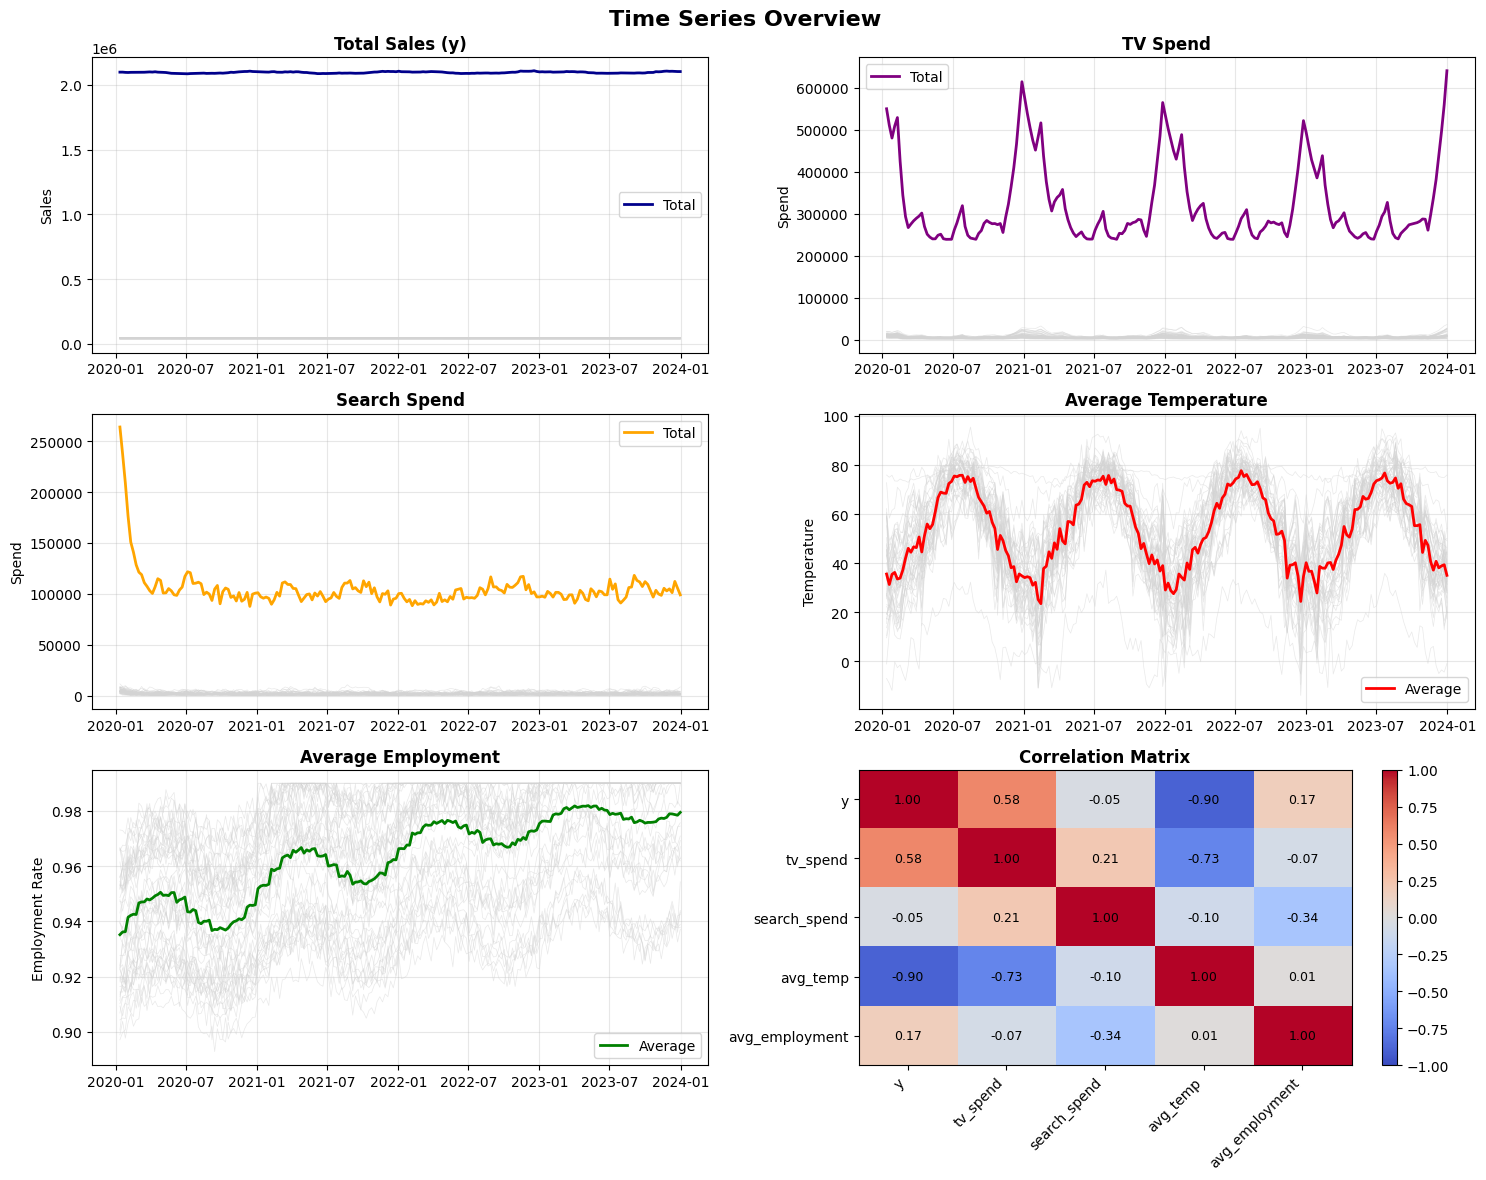

✓ Time series visualization complete

In [33]:
# Visualize the data
import matplotlib.pyplot as plt

def plot_time_series(df: pl.DataFrame) -> None:
    """Plot time series for key variables with all states in background."""
    # Aggregate by week (sum across states for spend/sales, mean for controls)
    df_agg = df.group_by("week").agg([
        pl.col("y").sum().alias("y"),
        pl.col("tv_spend").sum().alias("tv_spend"),
        pl.col("search_spend").sum().alias("search_spend"),
        pl.col("avg_temp").mean().alias("avg_temp"),
        pl.col("avg_employment").mean().alias("avg_employment"),
    ]).sort("week")
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle("Time Series Overview", fontsize=16, fontweight="bold")
    
    # Get all unique states
    states = df["state"].unique().to_list()
    
    # Sales - All states + Total
    for state in states:
        df_state = df.filter(pl.col("state") == state).sort("week")
        axes[0, 0].plot(df_state["week"], df_state["y"], color="lightgray", linewidth=0.5, alpha=0.5)
    axes[0, 0].plot(df_agg["week"], df_agg["y"], color="darkblue", linewidth=2, label="Total")
    axes[0, 0].set_title("Total Sales (y)", fontweight="bold")
    axes[0, 0].set_ylabel("Sales")
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # TV Spend - All states + Total
    for state in states:
        df_state = df.filter(pl.col("state") == state).sort("week")
        axes[0, 1].plot(df_state["week"], df_state["tv_spend"], color="lightgray", linewidth=0.5, alpha=0.5)
    axes[0, 1].plot(df_agg["week"], df_agg["tv_spend"], color="purple", linewidth=2, label="Total")
    axes[0, 1].set_title("TV Spend", fontweight="bold")
    axes[0, 1].set_ylabel("Spend")
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Search Spend - All states + Total
    for state in states:
        df_state = df.filter(pl.col("state") == state).sort("week")
        axes[1, 0].plot(df_state["week"], df_state["search_spend"], color="lightgray", linewidth=0.5, alpha=0.5)
    axes[1, 0].plot(df_agg["week"], df_agg["search_spend"], color="orange", linewidth=2, label="Total")
    axes[1, 0].set_title("Search Spend", fontweight="bold")
    axes[1, 0].set_ylabel("Spend")
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Temperature - All states + Average
    for state in states:
        df_state = df.filter(pl.col("state") == state).sort("week")
        axes[1, 1].plot(df_state["week"], df_state["avg_temp"], color="lightgray", linewidth=0.5, alpha=0.5)
    axes[1, 1].plot(df_agg["week"], df_agg["avg_temp"], color="red", linewidth=2, label="Average")
    axes[1, 1].set_title("Average Temperature", fontweight="bold")
    axes[1, 1].set_ylabel("Temperature")
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Employment - All states + Average
    for state in states:
        df_state = df.filter(pl.col("state") == state).sort("week")
        axes[2, 0].plot(df_state["week"], df_state["avg_employment"], color="lightgray", linewidth=0.5, alpha=0.5)
    axes[2, 0].plot(df_agg["week"], df_agg["avg_employment"], color="green", linewidth=2, label="Average")
    axes[2, 0].set_title("Average Employment", fontweight="bold")
    axes[2, 0].set_ylabel("Employment Rate")
    axes[2, 0].legend()
    axes[2, 0].grid(alpha=0.3)
    
    # Correlation heatmap
    corr_data = df_agg.select([
        "y", "tv_spend", "search_spend", "avg_temp", "avg_employment"
    ]).to_pandas().corr()
    
    im = axes[2, 1].imshow(corr_data, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto")
    axes[2, 1].set_xticks(range(len(corr_data.columns)))
    axes[2, 1].set_yticks(range(len(corr_data.columns)))
    axes[2, 1].set_xticklabels(corr_data.columns, rotation=45, ha="right")
    axes[2, 1].set_yticklabels(corr_data.columns)
    axes[2, 1].set_title("Correlation Matrix", fontweight="bold")
    
    # Add correlation values
    for i in range(len(corr_data.columns)):
        for j in range(len(corr_data.columns)):
            text = axes[2, 1].text(j, i, f"{corr_data.iloc[i, j]:.2f}",
                                  ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=axes[2, 1])
    plt.tight_layout()
    plt.show()

plot_time_series(df)

rprint("[bold green]✓[/bold green] Time series visualization complete")


In [34]:
# Create summary table of average spend by state
non_null_y_count = df.filter(pl.col("y").is_not_null()).shape[0]
total_count = df.shape[0]
rprint(f"[yellow]Data check:[/yellow] {non_null_y_count} non-null sales values out of {total_count} total rows")

# Aggregate spend and sales data
spend_summary = (
    df.group_by("state")
    .agg([
        pl.col("tv_spend").mean().alias("Avg TV Spend"),
        pl.col("search_spend").mean().alias("Avg Search Spend"),
        (pl.col("tv_spend") + pl.col("search_spend")).mean().alias("Avg Total Spend"),
        pl.col("y").mean().alias("Avg Sales"),
    ])
    .sort("Avg Total Spend", descending=True)
)

# Display using Rich table
table = Table(title="Average Media Spend by State", show_header=True, header_style="bold magenta")
table.add_column("State", style="cyan", no_wrap=True)
table.add_column("Avg TV Spend", justify="right", style="green")
table.add_column("Avg Search Spend", justify="right", style="blue")
table.add_column("Avg Total Spend", justify="right", style="yellow")
table.add_column("Avg Sales", justify="right", style="magenta")

for row in spend_summary.iter_rows(named=True):
    avg_sales = row.get('Avg Sales')
    sales_str = f"${avg_sales:,.2f}" if avg_sales is not None and not np.isnan(avg_sales) else "$nan"
    
    table.add_row(
        row["state"],
        f"${row['Avg TV Spend']:,.2f}",
        f"${row['Avg Search Spend']:,.2f}",
        f"${row['Avg Total Spend']:,.2f}",
        sales_str
    )

console.print(table)
rprint(f"\n[bold green]✓[/bold green] Average spend summary for {len(spend_summary)} states")

Data check: 10400 non-null sales values out of 10400 total rows

                           Average Media Spend by State                            
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ State          ┃ Avg TV Spend ┃ Avg Search Spend ┃ Avg Total Spend ┃  Avg Sales ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Texas          │   $13,119.02 │        $3,488.64 │      $16,607.65 │ $44,563.98 │
│ New York       │   $11,110.87 │        $3,232.43 │      $14,343.30 │ $40,571.07 │
│ North Carolina │   $10,442.48 │        $2,585.67 │      $13,028.15 │ $36,077.00 │
│ California     │   $10,168.02 │        $2,853.00 │      $13,021.02 │ $46,568.23 │
│ Virginia       │   $10,028.41 │        $2,776.01 │      $12,804.43 │ $41,167.96 │
│ Florida        │    $8,662.81 │        $3,671.72 │      $12,334.53 │ $46,058.95 │
│ Michigan       │    $9,526.88 │        $2,208.14 │      $11,735.02 │ $43,541.15 │
│ Washington     │    $9,266.80 │        $2,318.26 │      $11,585.06 │ $45,027.23 │
│ Ohio           │    $8,592.62 │        $2,652.97 │      $11,245.59 │ $47,810.30 │
│ Arizona        │    $8,540.73 │        $2,396.62 │      $10,937.35 │ $37,023.59 │
│ Massachusetts  │    $8,453.45 │        $2,237.68 │      $10,691.13 │ $38,583.65 │
│ Maryland       │    $7,818.03 │        $2,811.47 │      $10,629.50 │ $38,382.23 │
│ Georgia        │    $8,134.42 │        $2,452.15 │      $10,586.57 │ $49,311.96 │
│ New Jersey     │    $7,815.47 │        $2,533.53 │      $10,349.00 │ $47,395.09 │
│ Tennessee      │    $7,057.37 │        $2,991.86 │      $10,049.22 │ $36,561.22 │
│ Pennsylvania   │    $7,011.23 │        $2,591.39 │       $9,602.62 │ $36,522.99 │
│ Illinois       │    $6,918.14 │        $2,527.18 │       $9,445.32 │ $41,458.58 │
│ Indiana        │    $6,783.76 │        $2,466.04 │       $9,249.80 │ $42,577.13 │
│ Colorado       │    $7,241.18 │        $1,940.75 │       $9,181.93 │ $42,659.58 │
│ Alabama        │    $6,741.88 │        $2,079.21 │       $8,821.09 │ $42,608.70 │
│ Utah           │    $6,296.27 │        $2,010.29 │       $8,306.56 │ $42,697.24 │
│ Minnesota      │    $5,863.78 │        $2,423.63 │       $8,287.42 │ $43,886.93 │
│ Wisconsin      │    $6,133.24 │        $2,137.53 │       $8,270.77 │ $38,823.46 │
│ Missouri       │    $6,118.05 │        $2,140.19 │       $8,258.24 │ $41,646.40 │
│ South Carolina │    $5,852.71 │        $2,351.09 │       $8,203.80 │ $41,826.13 │
│ Louisiana      │    $5,740.20 │        $2,419.14 │       $8,159.34 │ $40,197.79 │
│ Kentucky       │    $6,206.40 │        $1,788.57 │       $7,994.97 │ $40,409.35 │
│ Oklahoma       │    $5,672.99 │        $2,252.08 │       $7,925.07 │ $44,168.58 │
│ Nevada         │    $5,819.73 │        $1,861.21 │       $7,680.94 │ $39,540.26 │
│ Oregon         │    $5,478.41 │        $2,163.56 │       $7,641.97 │ $45,645.29 │
│ Arkansas       │    $5,386.22 │        $2,204.78 │       $7,590.99 │ $37,938.06 │
│ Connecticut    │    $5,363.95 │        $2,102.55 │       $7,466.50 │ $38,423.62 │
│ Rhode Island   │    $5,907.17 │        $1,538.08 │       $7,445.26 │ $40,347.66 │
│ Iowa           │    $5,342.37 │        $2,025.32 │       $7,367.69 │ $42,526.36 │
│ Mississippi    │    $5,230.54 │        $2,019.36 │       $7,249.91 │ $40,926.04 │
│ Kansas         │    $4,852.29 │        $1,849.73 │       $6,702.03 │ $39,698.36 │
│ South Dakota   │    $4,745.62 │        $1,605.33 │       $6,350.95 │ $47,893.26 │
│ New Mexico     │    $4,455.08 │        $1,806.37 │       $6,261.46 │ $38,157.56 │
│ Nebraska       │    $4,830.44 │        $1,383.80 │       $6,214.24 │ $39,691.08 │
│ Montana        │    $4,816.72 │        $1,270.47 │       $6,087.19 │ $40,588.26 │
│ Idaho          │    $4,088.37 │        $1,679.87 │       $5,768.25 │ $47,878.32 │
│ West Virginia  │    $4,149.01 │        $1,392.10 │       $5,541.11 │ $42,520.13 │
│ North Dakota   │    $4,425.96 │        $1,111.71 │       $5,537.67 │ $38,079.59 │
│ Hawaii         │    $4,070.03 │        $1,300.52 │

✓ Average spend summary for 50 states

## Split Data into Training and Test Sets

- **Training**: Years 1-3 (156 weeks) - used to fit the MMM
- **Test**: Year 4 (52 weeks) - used to evaluate forecasts


In [35]:
# Split data
split_date = pl.date(2023, 1, 1)
train_data = df.filter(pl.col("week") < split_date)
test_data = df.filter(pl.col("week") >= split_date)

rprint(f"[bold cyan]Training data:[/bold cyan] {train_data.shape[0]} rows ({train_data['week'].min()} to {train_data['week'].max()})")
rprint(f"[bold cyan]Test data:[/bold cyan] {test_data.shape[0]} rows ({test_data['week'].min()} to {test_data['week'].max()})")

# Define column names
channel_columns = ["tv_spend", "search_spend"]
control_columns = ["avg_employment", "avg_temp"]
date_column = "week"


Training data: 7750 rows (2020-01-12 to 2022-12-25)

Test data: 2650 rows (2023-01-01 to 2023-12-31)

## Fit PyMC-Marketing MMM on Training Data

We fit the MMM to learn:
- **Media effects** (β_tv, β_search): How each channel affects sales
- **Control effects** (γ_employment, γ_temp): Impact of external factors
- **Transformation parameters** (adstock, saturation): How media accumulates and saturates


In [ ]:
# 1) To pandas and basic hygiene
train_df = train_data.to_pandas()
train_df[date_column] = pd.to_datetime(train_df[date_column])
train_df = train_df.sort_values(["state", date_column]).reset_index(drop=True)

# 2) Build X (features) and y (target)
feature_cols = [date_column, "state"] + channel_columns + control_columns
X = train_df[feature_cols].copy()
y = train_df["y"]

assert 'state' in X.columns, "state must be present in X"

# 3) Configure reduced sampling for faster execution with improved settings to reduce divergences
# Using 300 draws instead of 1000 for ~3x speedup while maintaining reasonable accuracy
# Increased target_accept to 0.95 to reduce divergences (though sampling will be slower)
sampler_config = {
    "draws": 200,
    "tune": 500,
    "chains": 4,
    # "target_accept": 0.95,  # Increased from 0.85 to reduce divergences
    # "max_treedepth": 12,  # Increased to allow more exploration
}

rprint("[yellow]Training MMM with reduced sampling for faster execution (300 draws, 2 chains)[/yellow]")
rprint("[dim]For production use, increase draws to 1000+ and use 4 chains for better convergence[/dim]")

# 4) Define and fit the multidimensional MMM
mmm = MMM(
    date_column=date_column,
    channel_columns=channel_columns,
    adstock=GeometricAdstock(l_max=13),
    saturation=LogisticSaturation(),
    yearly_seasonality=3,
    control_columns=control_columns,
    target_column="y",
    dims=("state",),
    sampler_config=sampler_config,  # Pass sampler_config to constructor
)

mmm.fit(X, y)

rprint("[bold green]✓ MMM training complete[/bold green]")

Training MMM with reduced sampling for faster execution (300 draws, 2 chains)

For production use, increase draws to 1000+ and use 4 chains for better convergence

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1957 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ MMM training complete

## Forecast Control Variables with Chronos2

Now we use **Chronos2** (a foundational time series model) to forecast the control variables for Year 4. This is the key innovation: using a powerful predictive model to estimate variables we don't yet know.


In [39]:
def forecast_controls_with_chronos2(train_data: pl.DataFrame, control_cols: list[str], prediction_length: int = 52, device: str = "cpu") -> pl.DataFrame:
    from chronos import Chronos2Pipeline
    import torch
    quantile_levels = (0.1, 0.5, 0.9)
    
    # Force single-threaded execution for PyTorch DataLoader to avoid multiprocessing issues in notebooks
    torch.set_num_threads(1)
    
    # 1) Load Chronos-2
    pipeline = Chronos2Pipeline.from_pretrained(
        "s3://autogluon/chronos-2",
        device_map=("cuda" if device == "cuda" else "cpu"),
        dtype=torch.bfloat16,
    )

    # 2) Prepare global context DataFrame for Chronos-2 (pandas I/O)
    needed = ["state", "week"] + control_cols
    df = (
        train_data
        .select(needed)
        .sort(["state", "week"])
        .to_pandas()
        .rename(columns={"state": "id", "week": "timestamp"})
    )

    # Basic cleaning for targets
    for c in control_cols:
        s = df[c].astype("float32")
        if s.isna().any():
            mean_val = float(s.mean()) if pd.notna(s.mean()) else 0.0
            s = s.fillna(mean_val)
        df[c] = s

    # 3) One global call with multiple IDs and multiple targets
    # Force num_workers=0 to avoid multiprocessing issues
    q_levels = list(quantile_levels) if quantile_levels else None
    pred_df = pipeline.predict_df(
        df,
        prediction_length=prediction_length,
        quantile_levels=q_levels,
        id_column="id",
        timestamp_column="timestamp",
        target=control_cols,  # multi-output
    )
    print(pred_df.columns.tolist())
    # pred_df columns include: ['id','timestamp','target','predictions', *quantiles...]

    # 4) Pivot to wide per state-week for mean prediction
    mean_wide = (
        pred_df.pivot(index=["timestamp", "id"], columns="target_name", values="predictions")
        .reset_index()
        .rename(columns={c: f"{c}_forecast" for c in control_cols})
    )

    # 5) Pivot quantiles to wide and merge
    merged = mean_wide
    if q_levels:
        for q in q_levels:
            qcol = f"{q:.1f}" if isinstance(q, float) else str(q)
            if qcol in pred_df.columns:
                qw = (
                    pred_df.pivot(index=["timestamp", "id"], columns="target_name", values=qcol)
                    .reset_index()
                    .rename(columns={c: f"{c}_q{int(round(float(q)*100)):02d}" for c in control_cols})
                )
                merged = merged.merge(qw, on=["timestamp", "id"], how="left")

    # 6) Back to Polars, rename to original keys, tidy ordering
    result = (
        pl.from_pandas(merged)
        .rename({"timestamp": "week", "id": "state"})
        .sort(["state", "week"])
    )

    return result

rprint("[yellow]Generating Chronos2 forecasts (this may take a few minutes)...[/yellow]")
control_forecasts = forecast_controls_with_chronos2(
    train_data,
    control_columns,
    prediction_length=52,
    device="cpu",  # Change to "cuda" if GPU available
)
rprint("[bold green]✓ Chronos2 forecasts complete[/bold green]")

Generating Chronos2 forecasts (this may take a few minutes)...

RuntimeError: Broken pipe

In [ ]:
control_forecasts

week,state,avg_employment_forecast,avg_temp_forecast,avg_employment_q10,avg_temp_q10,avg_employment_q50,avg_temp_q50,avg_employment_q90,avg_temp_q90
datetime[ns],str,f32,f32,f32,f32,f32,f32,f32,f32
2023-01-01 00:00:00,"""Alabama""",0.984375,46.75,0.980469,39.5,0.984375,46.75,0.988281,54.0
2023-01-08 00:00:00,"""Alabama""",0.984375,46.5,0.984375,39.0,0.984375,46.5,0.988281,53.75
2023-01-15 00:00:00,"""Alabama""",0.988281,46.5,0.984375,38.5,0.988281,46.5,0.9921875,54.0
2023-01-22 00:00:00,"""Alabama""",0.988281,47.25,0.988281,39.5,0.988281,47.25,0.9921875,54.5
2023-01-29 00:00:00,"""Alabama""",0.9921875,47.75,0.988281,41.0,0.9921875,47.75,0.996094,55.25
…,…,…,…,…,…,…,…,…,…
2023-11-26 00:00:00,"""Wyoming""",0.988281,19.125,0.984375,6.03125,0.988281,19.125,0.988281,29.125
2023-12-03 00:00:00,"""Wyoming""",0.988281,17.25,0.980469,5.71875,0.988281,17.25,0.988281,26.125
2023-12-10 00:00:00,"""Wyoming""",0.988281,15.5625,0.980469,3.875,0.988281,15.5625,0.988281,23.875


Chronos2 Forecast Accuracy Metrics

            Control Variable Forecast Accuracy            
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ Control Variable ┃    MAE ┃   RMSE ┃ MAPE (%) ┃     R² ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ avg_employment   │ 0.0040 │ 0.0060 │     0.41 │ 0.8880 │
│ avg_temp         │ 4.1882 │ 5.3649 │    15.17 │ 0.9195 │
└──────────────────┴────────┴────────┴──────────┴────────┘

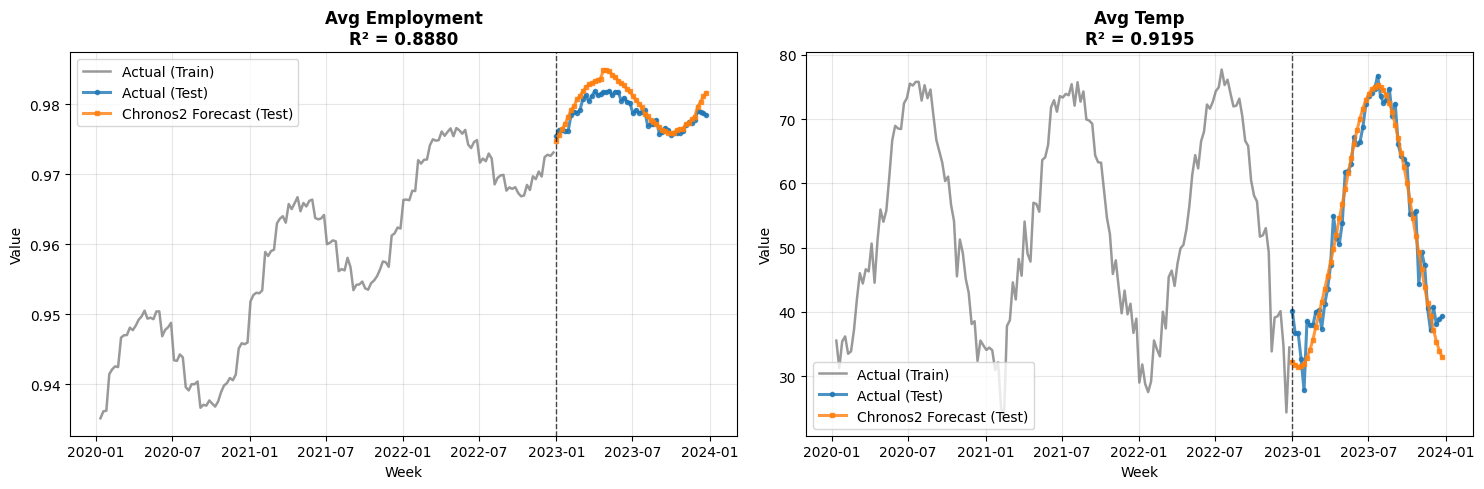

✓ Forecast evaluation complete

In [ ]:
# Merge forecasts with actual test data
test_data_pd = test_data.to_pandas()
test_controls_actual = test_data_pd[["week", "state"] + control_columns].copy()

# Also prepare TRAINING actuals for plotting
# Use existing train_df prepared earlier
train_controls_actual = train_df[["week", "state"] + control_columns].copy()

# Convert forecasts to pandas
control_forecasts_pd = control_forecasts.to_pandas()

# Merge actual and forecasted (TEST period)
comparison_data = test_controls_actual.merge(
    control_forecasts_pd,
    on=["week", "state"],
    how="inner"
)

# Calculate metrics for each control variable
def calculate_metrics(actual: np.ndarray, predicted: np.ndarray) -> dict:
    """Calculate accuracy metrics."""
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mape = np.mean(np.abs((actual - predicted) / (np.abs(actual) + 1e-8))) * 100
    r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R²": r2}

# Compute metrics per control variable (TEST period)
rprint("[bold cyan]Chronos2 Forecast Accuracy Metrics[/bold cyan]")
metrics_summary = {}

for control in control_columns:
    actual_col = control
    forecast_col = f"{control}_forecast"
    
    actual_values = comparison_data[actual_col].values
    forecast_values = comparison_data[forecast_col].values
    
    # Filter out NaN values
    valid_mask = ~(np.isnan(actual_values) | np.isnan(forecast_values))
    actual_values = actual_values[valid_mask]
    forecast_values = forecast_values[valid_mask]
    
    metrics = calculate_metrics(actual_values, forecast_values)
    metrics_summary[control] = metrics

# Display metrics table
metrics_table = Table(
    title="Control Variable Forecast Accuracy",
    show_header=True,
    header_style="bold magenta"
)
metrics_table.add_column("Control Variable", style="cyan")
metrics_table.add_column("MAE", justify="right", style="green")
metrics_table.add_column("RMSE", justify="right", style="yellow")
metrics_table.add_column("MAPE (%)", justify="right", style="blue")
metrics_table.add_column("R²", justify="right", style="magenta")

for control, metrics in metrics_summary.items():
    metrics_table.add_row(
        control,
        f"{metrics['MAE']:.4f}",
        f"{metrics['RMSE']:.4f}",
        f"{metrics['MAPE']:.2f}",
        f"{metrics['R²']:.4f}",
    )

console.print(metrics_table)

# Plot forecast vs actual (TEST) and actuals (TRAIN) for each control variable
fig, axes = plt.subplots(1, len(control_columns), figsize=(15, 5))
if len(control_columns) == 1:
    axes = [axes]

# Ensure datetime types and compute split timestamp from test_data
train_controls_actual["week"] = pd.to_datetime(train_controls_actual["week"])
comparison_data["week"] = pd.to_datetime(comparison_data["week"])
split_ts = pd.to_datetime(test_data_pd["week"].min())

for idx, control in enumerate(control_columns):
    actual_col = control
    forecast_col = f"{control}_forecast"

    # Aggregate by week (mean across states), sort by date
    train_weekly = (
        train_controls_actual.groupby("week")[actual_col]
        .mean()
        .sort_index()
    )
    test_actual_weekly = (
        comparison_data.groupby("week")[actual_col]
        .mean()
        .sort_index()
    )
    forecast_weekly = (
        comparison_data.groupby("week")[forecast_col]
        .mean()
        .sort_index()
    )

    # Plot with proper dates on x-axis
    axes[idx].plot(train_weekly.index, train_weekly.values, label="Actual (Train)", linewidth=1.8, color="gray", alpha=0.8)
    axes[idx].plot(test_actual_weekly.index, test_actual_weekly.values, label="Actual (Test)", linewidth=2.2, marker="o", markersize=3, alpha=0.8)
    axes[idx].plot(forecast_weekly.index, forecast_weekly.values, label="Chronos2 Forecast (Test)", linewidth=2.2, marker="s", markersize=3, alpha=0.8)

    # Mark train/test split
    axes[idx].axvline(split_ts, color="black", linestyle="--", linewidth=1, alpha=0.7)

    axes[idx].set_title(f"{control.replace('_', ' ').title()}\nR² = {metrics_summary[control]['R²']:.4f}", fontweight="bold")
    axes[idx].set_xlabel("Week")
    axes[idx].set_ylabel("Value")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

rprint("[bold green]✓ Forecast evaluation complete[/bold green]")


In [ ]:
control_forecasts_pd.head()

,week,state,avg_employment_forecast,avg_temp_forecast,avg_employment_q10,avg_temp_q10,avg_employment_q50,avg_temp_q50,avg_employment_q90,avg_temp_q90
0,2023-01-01,Alabama,0.984375,46.75,0.980469,39.5,0.984375,46.75,0.988281,54.00
1,2023-01-08,Alabama,0.984375,46.50,0.984375,39.0,0.984375,46.50,0.988281,53.75
2,2023-01-15,Alabama,0.988281,46.50,0.984375,38.5,0.988281,46.50,0.992188,54.00
3,2023-01-22,Alabama,0.988281,47.25,0.988281,39.5,0.988281,47.25,0.992188,54.50
4,2023-01-29,Alabama,0.992188,47.75,0.988281,41.0,0.992188,47.75,0.996094,55.25


In [ ]:
# ============================================================================
# Compare: Actual Sales vs MMM Predictions (Actual Controls vs Forecasted Controls)
# ============================================================================

def prepare_test_data_for_mmm(
    test_df: pl.DataFrame,
    date_col: str,
    channel_cols: list[str],
    control_cols: list[str],
    control_source: pl.DataFrame | None = None,
) -> pd.DataFrame:
    """Prepare test data for MMM prediction."""
    
    if control_source is None:
        # Use actual controls from test data
        df = test_df.select([date_col, "state"] + channel_cols + control_cols)
    else:
        # Replace controls with forecasted values
        # Cast both week columns to date type to avoid datetime mismatch
        test_prep = test_df.select([date_col, "state"] + channel_cols).with_columns(
            pl.col(date_col).cast(pl.Date)
        )
        control_prep = control_source.select(
            [date_col, "state"] + [f"{c}_forecast" for c in control_cols]
        ).with_columns(
            pl.col(date_col).cast(pl.Date)
        )
        
        df = (
            test_prep
            .join(control_prep, on=[date_col, "state"], how="left")
            .with_columns([
                pl.col(f"{c}_forecast").alias(c) for c in control_cols
            ])
            .select([date_col, "state"] + channel_cols + control_cols)
        )
    
    # Convert to pandas with proper types
    df_pd = df.sort(["state", date_col]).to_pandas()
    df_pd[date_col] = pd.to_datetime(df_pd[date_col])
    df_pd = df_pd.reset_index(drop=True)
    
    # Ensure numeric columns are float
    for col in channel_cols + control_cols:
        df_pd[col] = df_pd[col].astype(float)
    
    return df_pd

# Sort test data
test_sorted = test_data.sort(["state", date_column])

# SCENARIO 1: Predictions with ACTUAL controls
rprint("[bold yellow]Generating predictions with ACTUAL controls...[/bold yellow]")
X_actual = prepare_test_data_for_mmm(
    test_sorted, date_column, channel_columns, control_columns, control_source=None
)

# Generate predictions - returns xr.Dataset with 'y' variable
y_pred_dataset = mmm.sample_posterior_predictive(X=X_actual, extend_idata=False, combined=True)
y_pred_actual = y_pred_dataset["y"].mean(dim="sample").values.flatten()
rprint(f"[green]✓ Predictions with actual controls complete[/green]")

# SCENARIO 2: Predictions with FORECASTED controls
rprint("[bold yellow]Generating predictions with FORECASTED controls...[/bold yellow]")
X_forecasted = prepare_test_data_for_mmm(
    test_sorted, date_column, channel_columns, control_columns, control_source=control_forecasts
)

y_pred_dataset = mmm.sample_posterior_predictive(X=X_forecasted, extend_idata=False, combined=True)
y_pred_forecasted = y_pred_dataset["y"].mean(dim="sample").values.flatten()
rprint(f"[green]✓ Predictions with forecasted controls complete[/green]")

# Bring predictions back to original scale using target scaler
scales = mmm.get_scales_as_xarray()
target_scale_xr = scales["target_scale"]

# Determine per-row scale aligned to `state` (or scalar if no dims)
if len(target_scale_xr.dims) == 0:
    target_scale_per_row = np.full_like(y_pred_actual, float(target_scale_xr.values), dtype=float)
else:
    dim_name = list(target_scale_xr.dims)[0]  # e.g., "state"
    scale_df = target_scale_xr.to_dataframe(name="target_scale").reset_index()
    scale_map = dict(zip(scale_df[dim_name], scale_df["target_scale"]))
    target_states = test_sorted["state"].to_numpy()
    target_scale_per_row = np.array([float(scale_map[s]) for s in target_states], dtype=float)

# Denormalize
y_pred_actual_orig = y_pred_actual * target_scale_per_row
y_pred_forecasted_orig = y_pred_forecasted * target_scale_per_row

# Combine results
results = pl.DataFrame({
    "week": test_sorted[date_column].to_numpy(),
    "state": test_sorted["state"].to_numpy(), 
    "y_actual": test_sorted["y"].to_numpy(),
    "y_pred_actual_controls": y_pred_actual_orig,
    "y_pred_forecasted_controls": y_pred_forecasted_orig,
})

Generating predictions with ACTUAL controls...

Sampling: [y]


Output()

✓ Predictions with actual controls complete

Generating predictions with FORECASTED controls...

Sampling: [y]


Output()

✓ Predictions with forecasted controls complete

✓ Results combined: (2650, 8)

Diagnostics (means):

{
    'y_actual_mean': 41946.54018490566,
    'y_pred_actual_mean': 41867.20928018786,
    'y_pred_forecast_mean': 41278.06767486467
}

Diagnostics (pct zeros in predictions):

{'%zeros_pred_actual': 0.0, '%zeros_pred_forecast': 0.0}

             MMM Prediction Error: Actual vs Forecasted Controls              
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric ┃ With Actual Controls ┃ With Forecasted Controls ┃ Degradation (Δ) ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MAE    │           $14,601.67 │               $14,808.20 │        $+206.52 │
│ RMSE   │           $19,612.99 │               $20,107.67 │        $+494.68 │
│ MAPE   │               35.00% │                   35.43% │          +0.44% │
│ R²     │             -34.1300 │                 -35.9244 │         -1.7945 │
└────────┴──────────────────────┴──────────────────────────┴─────────────────┘

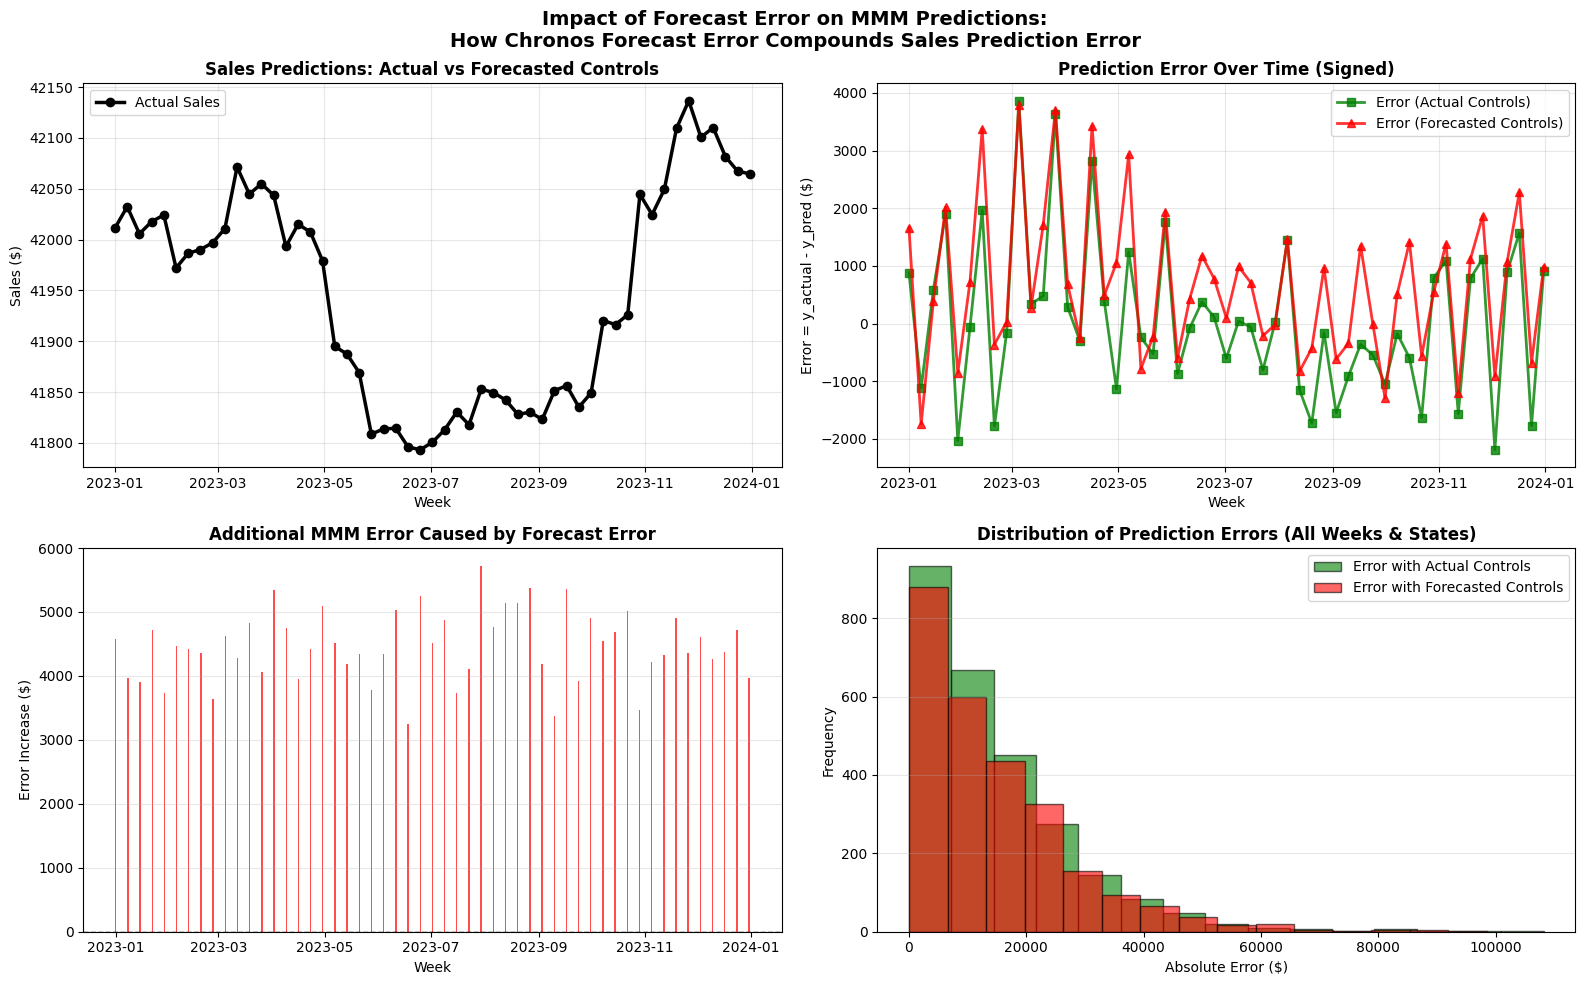

Key Findings:

• Average additional error from forecast: $4,461.43

• Maximum additional error: $31,627.13

• % of predictions worse with forecasted controls: 48.3%

• MAPE degradation: +0.44%

• RMSE degradation: $+494.68

In [ ]:
# Add error columns in separate steps
results = results.with_columns([
    (pl.col("y_actual") - pl.col("y_pred_actual_controls")).alias("error_actual_controls"),
    (pl.col("y_actual") - pl.col("y_pred_forecasted_controls")).alias("error_forecasted_controls"),
])

results = results.with_columns([
    (pl.col("error_forecasted_controls") - pl.col("error_actual_controls")).abs().alias("additional_error_from_forecast"),
])

rprint(f"[green]✓ Results combined: {results.shape}[/green]")

# Quick validation: shapes, NaNs, and ordering
assert len(y_pred_actual) == len(test_sorted), "Prediction length mismatch for actual-controls scenario"
assert len(y_pred_forecasted) == len(test_sorted), "Prediction length mismatch for forecasted-controls scenario"

# Convert to pandas for quick diagnostics
_results_pd = results.to_pandas()

# Basic diagnostics
rprint("[dim]Diagnostics (means):[/dim]")
rprint({
    "y_actual_mean": float(np.nanmean(_results_pd["y_actual"])),
    "y_pred_actual_mean": float(np.nanmean(_results_pd["y_pred_actual_controls"])),
    "y_pred_forecast_mean": float(np.nanmean(_results_pd["y_pred_forecasted_controls"]))
})
rprint("[dim]Diagnostics (pct zeros in predictions):[/dim]")
rprint({
    "%zeros_pred_actual": float(np.mean(np.isclose(_results_pd["y_pred_actual_controls"], 0.0))) * 100.0,
    "%zeros_pred_forecast": float(np.mean(np.isclose(_results_pd["y_pred_forecasted_controls"], 0.0))) * 100.0,
})

# Explicit NaN check
assert not _results_pd.isnull().any().any(), "Unexpected NaNs in results dataframe"

# ============================================================================
# Display Error Metrics Comparison
# ============================================================================
def compute_error_metrics(actual: np.ndarray, predicted: np.ndarray) -> dict:
    """Compute MAE, RMSE, MAPE, and R² metrics."""
    valid_mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual = actual[valid_mask]
    predicted = predicted[valid_mask]
    
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mape = np.mean(np.abs((actual - predicted) / (np.abs(actual) + 1e-8))) * 100
    r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))
    
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R²": r2}

# Compute metrics
actual_vals = results.select("y_actual").to_numpy().flatten()
pred_actual_vals = results.select("y_pred_actual_controls").to_numpy().flatten()
pred_forecast_vals = results.select("y_pred_forecasted_controls").to_numpy().flatten()

metrics_actual = compute_error_metrics(actual_vals, pred_actual_vals)
metrics_forecast = compute_error_metrics(actual_vals, pred_forecast_vals)

# Calculate the degradation
degradation = {k: metrics_forecast[k] - metrics_actual[k] for k in metrics_actual.keys()}

# Display comparison table
metrics_table = Table(
    title="MMM Prediction Error: Actual vs Forecasted Controls",
    show_header=True,
    header_style="bold magenta"
)
metrics_table.add_column("Metric", style="cyan")
metrics_table.add_column("With Actual Controls", justify="right", style="green")
metrics_table.add_column("With Forecasted Controls", justify="right", style="red")
metrics_table.add_column("Degradation (Δ)", justify="right", style="yellow")

for metric_name in ["MAE", "RMSE", "MAPE", "R²"]:
    actual_val = metrics_actual[metric_name]
    forecast_val = metrics_forecast[metric_name]
    delta = degradation[metric_name]
    
    # Format values
    if metric_name == "MAPE":
        actual_str = f"{actual_val:.2f}%"
        forecast_str = f"{forecast_val:.2f}%"
        delta_str = f"{delta:+.2f}%"
    elif metric_name == "R²":
        actual_str = f"{actual_val:.4f}"
        forecast_str = f"{forecast_val:.4f}"
        delta_str = f"{delta:+.4f}"
    else:
        actual_str = f"${actual_val:,.2f}"
        forecast_str = f"${forecast_val:,.2f}"
        delta_str = f"${delta:+,.2f}"
    
    metrics_table.add_row(metric_name, actual_str, forecast_str, delta_str)

console.print(metrics_table)

# ============================================================================
# Visualization: Show how forecast error compounds
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(
    "Impact of Forecast Error on MMM Predictions:\nHow Chronos Forecast Error Compounds Sales Prediction Error",
    fontsize=14,
    fontweight="bold"
)

# Aggregate by week for clearer visualization
results_agg = (
    results
    .group_by("week")
    .agg([
        pl.col("y_actual").mean().alias("y_actual"),
        pl.col("y_pred_actual_controls").mean().alias("y_pred_actual"),
        pl.col("y_pred_forecasted_controls").mean().alias("y_pred_forecast"),
        pl.col("error_actual_controls").mean().alias("error_actual"),
        pl.col("error_forecasted_controls").mean().alias("error_forecast"),
        pl.col("additional_error_from_forecast").mean().alias("additional_error"),
    ])
    .sort("week")
)

results_agg_pd = results_agg.to_pandas()
results_agg_pd["week"] = pd.to_datetime(results_agg_pd["week"])  # ensure datetime
x_dates = results_agg_pd["week"].values

# Plot 1: Actual vs Predicted (both scenarios)
axes[0, 0].plot(x_dates, results_agg_pd["y_actual"], label="Actual Sales", linewidth=2.5, marker="o", markersize=6, color="black")
axes[0, 0].set_title("Sales Predictions: Actual vs Forecasted Controls", fontweight="bold")
axes[0, 0].set_xlabel("Week")
axes[0, 0].set_ylabel("Sales ($)")
axes[0, 0].legend(loc="best")
axes[0, 0].grid(alpha=0.3)

# Plot 2: Prediction errors over time (signed differences)
axes[0, 1].plot(x_dates, results_agg_pd["error_actual"], label="Error (Actual Controls)", linewidth=2.0, marker="s", color="green", alpha=0.8)
axes[0, 1].plot(x_dates, results_agg_pd["error_forecast"], label="Error (Forecasted Controls)", linewidth=2.0, marker="^", color="red", alpha=0.8)
axes[0, 1].set_title("Prediction Error Over Time (Signed)", fontweight="bold")
axes[0, 1].set_xlabel("Week")
axes[0, 1].set_ylabel("Error = y_actual - y_pred ($)")
axes[0, 1].legend(loc="best")
axes[0, 1].grid(alpha=0.3)

# Plot 3: Additional error caused by forecast
axes[1, 0].bar(x_dates, results_agg_pd["additional_error"], color=["red" if x > 0 else "blue" for x in results_agg_pd["additional_error"]], alpha=0.7, label="Additional Error")
axes[1, 0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1, 0].set_title("Additional MMM Error Caused by Forecast Error", fontweight="bold")
axes[1, 0].set_xlabel("Week")
axes[1, 0].set_ylabel("Error Increase ($)")
axes[1, 0].grid(alpha=0.3, axis="y")

# Plot 4: Error distribution histogram
errors_actual = np.abs(results.select("error_actual_controls").to_numpy().flatten())
errors_forecast = np.abs(results.select("error_forecasted_controls").to_numpy().flatten())

axes[1, 1].hist(errors_actual, bins=15, alpha=0.6, label="Error with Actual Controls", color="green", edgecolor="black")
axes[1, 1].hist(errors_forecast, bins=15, alpha=0.6, label="Error with Forecasted Controls", color="red", edgecolor="black")
axes[1, 1].set_title("Distribution of Prediction Errors (All Weeks & States)", fontweight="bold")
axes[1, 1].set_xlabel("Absolute Error ($)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].legend(loc="best")
axes[1, 1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# ============================================================================
# Summary Statistics
# ============================================================================
avg_additional_error = results.select("additional_error_from_forecast").mean().item()
max_additional_error = results.select(pl.col("additional_error_from_forecast").abs()).max().item()
pct_worse = results.select((pl.col("error_forecasted_controls").abs() > pl.col("error_actual_controls").abs()).sum()).item() / len(results) * 100

rprint("\n[bold cyan]Key Findings:[/bold cyan]")
rprint(f"  • Average additional error from forecast: [yellow]${avg_additional_error:,.2f}[/yellow]")
rprint(f"  • Maximum additional error: [red]${max_additional_error:,.2f}[/red]")
rprint(f"  • % of predictions worse with forecasted controls: [red]{pct_worse:.1f}%[/red]")
rprint(f"\n  • MAPE degradation: [red]{degradation['MAPE']:+.2f}%[/red]")
rprint(f"  • RMSE degradation: [red]${degradation['RMSE']:+,.2f}[/red]")

### Control MAPE to MMM MAPE: exact relation (simplified notation)

Let $y$ be observed sales and $\hat{y}$ the MMM prediction. Decompose the MMM as a fixed media term $m$ plus a linear control term with coefficients $\gamma \in \mathbb{R}^p$ and controls $x \in \mathbb{R}^p$:

$$
\hat{y} = m + \gamma^\top x
$$

When using forecasted controls $\hat{x}$, the new prediction is

$$
\hat{y}_{\mathrm{fc}} = m + \gamma^\top \hat{x}
$$

This yields the exact change in prediction:

$$
\Delta \hat{y} := \hat{y}_{\mathrm{fc}} - \hat{y} = \gamma^\top (\hat{x} - x) = \sum_{j=1}^p \gamma_j\,\Delta x_j, \qquad \Delta x := \hat{x} - x
$$

Define per-row absolute percentage error (APE) as

$$
\mathrm{APE}(\hat{y}) = \frac{|y - \hat{y}|}{|y|}
$$

The additional APE from using forecasted controls is defined exactly by

$$
\Delta \mathrm{APE} = \mathrm{APE}(\hat{y}_{\mathrm{fc}}) - \mathrm{APE}(\hat{y})
= \frac{\,|y - (m + \gamma^\top \hat{x})| - |y - (m + \gamma^\top x)|\,}{|y|}
$$

A useful deterministic bound (no approximation of $\Delta \hat{y}$) follows from the triangle inequality:

$$
|\Delta \mathrm{APE}| \leq \frac{|\Delta \hat{y}|}{|y|} = \frac{|\gamma^\top \Delta x|}{|y|} \leq \sum_{j=1}^p \frac{|\gamma_j|\,|\Delta x_j|}{|y|}
$$

Taking expectations over rows (or time) gives an exact identity for the mean change and a bound for its magnitude:

$$
\mathbb{E}[\Delta \mathrm{APE}] = \mathbb{E}\left[\frac{|y - m - \gamma^\top \hat{x}| - |y - m - \gamma^\top x|}{|y|}\right], \qquad
\mathbb{E}[|\Delta \mathrm{APE}|] \leq \mathbb{E}\left[\frac{|\gamma^\top \Delta x|}{|y|}\right]
$$

If one wishes to relate this to control MAPEs, write $\mathrm{MAPE}_j := \mathbb{E}[|\Delta x_j|/|x_j|]$ and use data-driven weights $w_j := \mathbb{E}[|\gamma_j|\,|x_j|/|y|]$; then

$$
\mathbb{E}[|\Delta \mathrm{APE}|] \leq \sum_{j=1}^p w_j \,\mathrm{MAPE}_j
$$

which is a bound (not an approximation). In the code, we estimate $\gamma$ from the MMM posterior and the expectations by sample averages on the test set.


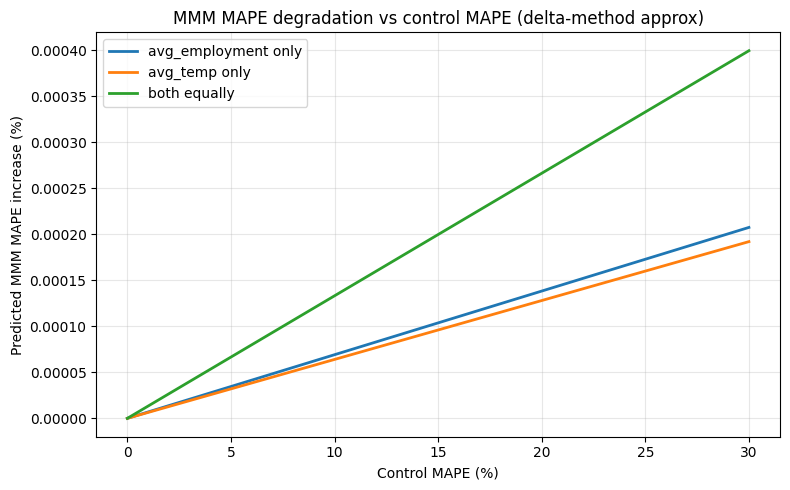

In [ ]:
# Plot: MMM MAPE degradation vs control MAPE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recompute robust weights w_j = E(|γ_j|·|x_j|/|y|) using same masking/alignment logic
results_pd = results.to_pandas().copy()
cd = comparison_data.copy()
cd['week'] = pd.to_datetime(cd['week'])
keys = results_pd[['week', 'state']].copy()
keys['week'] = pd.to_datetime(keys['week'])
cd_aligned = keys.merge(cd, on=['week', 'state'], how='left', validate='many_to_one')

y_vals = results_pd['y_actual'].to_numpy(dtype=float)
finite_y = np.isfinite(y_vals)
nonzero_y = np.abs(y_vals) > 1e-8

# Posterior |gamma| mean per control (averaged across states if present)
post = mmm.idata.posterior
gamma = post['gamma_control']
gamma_mean = gamma.mean(dim=[d for d in gamma.dims if d in ('chain', 'draw')])
if 'state' in gamma_mean.dims:
    gamma_abs_vec = np.abs(gamma_mean).mean(dim='state').values
else:
    gamma_abs_vec = np.abs(gamma_mean).values
if 'control' in gamma_mean.dims and 'control' in gamma_mean.coords:
    control_names = [str(c) for c in gamma_mean.coords['control'].values]
else:
    control_names = list(control_columns)

gamma_abs_by_control = {name: float(val) for name, val in zip(control_names, np.ravel(gamma_abs_vec))}

weights = {}
for c in control_columns:
    x_vals = cd_aligned[c].to_numpy(dtype=float)
    mask = np.isfinite(x_vals) & finite_y & nonzero_y
    if np.any(mask):
        weights[c] = float(np.mean(np.abs(gamma_abs_by_control.get(c, 0.0) * x_vals[mask]) / (np.abs(y_vals[mask]) + 1e-8)))
    else:
        weights[c] = 0.0

# Build grid of control MAPE values (percent)
m_grid = np.linspace(0.0, 30.0, 61)  # 0% .. 30%

# Scenario curves (percent):
# - vary each control individually (others 0)
# - vary both equally
curves = {}
for c in control_columns:
    w = weights[c]
    curves[f'{c} only'] = w * (m_grid / 100.0) * 100.0

w_sum = sum(weights[c] for c in control_columns)
curves['both equally'] = w_sum * (m_grid / 100.0) * 100.0

# Plot
plt.figure(figsize=(8, 5))
for label, vals in curves.items():
    plt.plot(m_grid, vals, linewidth=2, label=label)

plt.title('MMM MAPE degradation vs control MAPE (delta-method approx)')
plt.xlabel('Control MAPE (%)')
plt.ylabel('Predicted MMM MAPE increase (%)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
